In [1]:
%matplotlib widget
#matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import aseg_gdf2
from shapely.geometry import Point, LineString, MultiPoint
from shapely.wkt import loads
from scipy.io import loadmat
from scipy import spatial
import matplotlib.pyplot as plt
import rasterio
import netCDF4
import h5py
import gc
import os
import glob
from scipy.spatial.ckdtree import cKDTree
from hydrogeol_utils import SNMR_utils, spatial_functions, AEM_utils
from hydrogeol_utils import plotting_utils as plot_utils

In [4]:
def nearest_neighbours(points, coords, points_required = 1, max_distance = 250.):
    """

    :param points: array of points to find the nearest neighbour for
    :param coords: coordinates of points
    :param points_required: number of points to return
    :param max_distance: maximum search radius
    :return:
    """
    # Initialise tree instance
    kdtree = cKDTree(data=coords)

    # iterate throught the points and find the nearest neighbour
    distances, indices = kdtree.query(points, k=points_required,
                                      distance_upper_bound=max_distance)
    # Mask out infitnite distances in indices to avoid confusion
    mask = ~np.isfinite(distances)

    distances[mask] = np.nan

    return distances, indices

# Find the nearest neighbours within the maximum distance

def xy_2_var(grid_dict, xy, var):
    """
    Function for finding a variable for gridded AEM sections
    given an input easting and northing
    @ param: grid_dict :dictionary for gridded line data
    @ param: xy: numpy array with easting and northing
    @ param: var: string with variable name
    returns
    float: distance along line
    """
    utm_coords = np.column_stack((grid_dict['easting'],
                                  grid_dict['northing']))

    d, i = spatial_functions.nearest_neighbours(xy,
                                                utm_coords,
                                                points_required=1,
                                                max_distance=200.)

    near_ind = i[0]

    return grid_dict[var][near_ind]


In [5]:
infile = r"C:\Users\PCUser\Desktop\AEM\LCI\HowardE_WB_MGA52.nc"

lci_dat = netCDF4.Dataset(infile)

lci_coords = np.column_stack((lci_dat['easting'][:],
                          lci_dat['northing'][:]))

# Initialise tree instance for nearest neighbour searches
kdtree = cKDTree(data=lci_coords)


# bring in the rjmcmc data

infile = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\garjmcmc\combined\HE_rjmcmc_.nc"

# Read in the data

rj_dat = netCDF4.Dataset(infile)



In [6]:
rj_dat

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Dataset read from ASEG-GDF file rjmcmc.dat
    Conventions: CF-1.6,ACDD-1.3
    featureType: trajectory
    geospatial_vertical_min: -20.9
    geospatial_vertical_max: 34.3
    geospatial_vertical_units: m
    geospatial_vertical_resolution: point
    geospatial_vertical_positive: up
    history: Converted from ASEG-GDF file C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\garjmcmc\combined\rjmcmc.dat using definitions file C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\garjmcmc\combined\rjmcmc.dfn
    date_created: 2019-12-23T15:15:10.409710
    geospatial_east_resolution: point
    geospatial_north_resolution: point
    geospatial_east_min: 730488.1875
    geospatial_east_max: 740655.1875
    geospatial_east_units: m
    geospatial_north_min: 8613396.0
    geospatial_north_max: 8623772.0
    geospatial_north_units: m
    geospatial_bounds: POLYGON((730488.1875 8613396.0000, 735163.1250 8623566.

In [7]:
# Since we will be wanting to plot the sections lets first grid them

# Create an instance of plots for gridding the data

plots = plot_utils.ConductivitySectionPlot(lci_dat)


# Define some key variables which we want to inteprolate

cond_vars = ['conductivity', 'data_residual', 'depth_of_investigation']

plots.conductivity_variables = cond_vars


# Define the resolution of th sections
xres, yres = 10., 2.


In [8]:
# We will use the lines from the rj

lines = rj_dat['line'][:]

# Now grid the lines and save in memory

hdf5_dir = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\lci\hdf5"

gridded_vars ={}

# Saved these out to save time

#gridded_vars = plots.grid_variables(xres = xres, yres =yres, lines=lines,
#                                    resampling_method = 'cubic', save_hdf5 = True,
#                                    return_dict = True, hdf5_dir = hdf5_dir)

for line in lines:
    
    infile = os.path.join(hdf5_dir, str(line) + '.hdf5')
    f = h5py.File(infile, 'r')
    gridded_vars[line] = plot_utils.extract_hdf5_data(f, cond_vars)
    f = None
    gc.collect()

In [9]:
# Now we bring in the magnetics to plot

inRaster = r"C:\Users\PCUser\Desktop\NSC_data\data\Magnetics\HE\HE_TMA_rtp_1VD.tif"

mag_dataset = rasterio.open(inRaster)

mag = mag_dataset.read(1)

mag[mag == mag_dataset.get_nodatavals()] = np.nan


In [10]:
# Now we bring in the magnetics to plot

inRaster = r"C:\Users\PCUser\Desktop\2017_HowardsEast_SkyTEM\03_LCI\03_Depth_Slices\Grids_doi_Masked\*.ers"

cond = {}

for file in glob.glob(inRaster):
    layer = int(file.split('Con')[1].split('_')[0])
    cond_dataset = rasterio.open(file)
    cond[layer] = cond_dataset.read(1)



In [11]:
# Bring in a subset of the points to sample

infile = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\garjmcmc\combined\rjmcmc_map.csv"

df_all = pd.read_csv(infile)


In [11]:
# import a gis based interp on where the dykes are

df_dykes = gpd.read_file(r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\interpretation\dykes_AEM.shp")

df_dykes
 
poly1 = LineString(df_dykes.geometry.iloc[0]).buffer(40.)

#poly2 =  LineString(df_dykes.geometry.iloc[1]).buffer(30.)


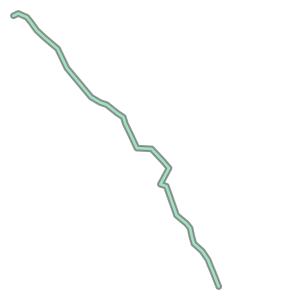

In [12]:
poly1

In [13]:
xs, ys = df_all['easting'].values, df_all['northing'].values

points = [Point(xs[i], ys[i]) for i in range(len(xs))]

mask = np.array([poly1.contains(pt) for pt in points])# + np.array([poly2.contains(pt) for pt in points])

df_rj_ss = df_all[mask]

for index, row in df_rj_ss.iterrows():
    # get the line and coordinates
    line = row['line']
    
    xy = np.array([row[['easting','northing']].values])
        
    df_rj_ss.loc[index,'dist_along_line'] = xy_2_var(gridded_vars[line],
                                               xy,'grid_distances')

    
print(len(df_rj_ss))
df_rj_ss.sort_values(by=['easting'], inplace = True) 
dyke_elevs = {}

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


158


C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
# Bring in a subset of the points to sample

infile = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\garjmcmc\combined\rjmcmc_map.csv"

df = pd.read_csv(infile)

# Add the distance along the gridded lines to the dataframe

for index, row in df.iterrows():
    # get the line and coordinates
    line = row['line']
    
    xy = np.array([row[['easting','northing']].values])
        
    df.loc[index,'dist_along_line'] = xy_2_var(gridded_vars[line],
                                               xy,'grid_distances')


In [13]:
# This function stores the top of the conductor in the dataframe on a click
def onclick(event):
    if event.xdata != None and event.ydata != None:
        dyke_elevs[ind].append(df_rj_ss.loc[ind, 'elevation'] - event.ydata)


In [14]:
# Create a generator to iterate through the pandas dataframe

def gen(df):
    for index, row in df.iterrows():
        yield index, row
        
#cond_gen = gen(df_rj_ss)


In [52]:
def extract_data():
    """
    FUnction for extracting all the AEM data from the netCDF files
    """

    freq = rj_dat['conducitivty_bin_count'][point_ind_rj].data.astype(np.float)

    cond_pdf = freq / freq.sum(axis =1)[0]

    cond_pdf[cond_pdf == 0] = np.nan
    
    cp_freq = rj_dat['change_point'][point_ind_rj].data.astype(np.float)
    
    cp_pdf = cp_freq / freq.sum(axis =1)[0]
    
    laybins = rj_dat['nlayer_bin_count'][point_ind_rj].data
    
    lay_prob = laybins / freq.sum(axis =1)[0]
    
    cond_cells = rj_dat["conductivity_cells"][:].data
    
    depth_cells = rj_dat['layer_top_depth'][point_ind_rj].data
    
    extent = [cond_cells.min(), cond_cells.max(), depth_cells.max(), depth_cells.min()]
    
    mean = rj_dat['conductivity_mean'][point_ind_rj].data
    p10 = rj_dat['conductivity_p10'][point_ind_rj].data
    p50 = rj_dat['conductivity_p50'][point_ind_rj].data
    p90 = rj_dat['conductivity_p90'][point_ind_rj].data
    
    lci_cond = lci_dat['conductivity'][point_ind_lci].data
    lci_depth_top = lci_dat['layer_top_depth'][point_ind_lci].data
    
    lci_doi = lci_dat['depth_of_investigation'][point_ind_lci].data
    
    misfit = rj_dat['misfit'][point_ind_rj].data
    sample_no = rj_dat['rj_sample_number'][:].data
    
    burnin = rj_dat["nburnin"][point_ind_rj].data
    nsamples = rj_dat['nsamples'][point_ind_rj].data
    nchains = rj_dat['nchains'][point_ind_rj].data
    
    line_ind = rj_dat['line_index'][point_ind_rj].data
    line = int(rj_dat['line'][line_ind].data)
    
    return {'conductivity_pdf': cond_pdf, "change_point_pdf": cp_pdf, "conductivity_extent": extent,
           'cond_p10': p10, 'cond_p50': p50, 'cond_p90': p90, 'cond_mean': mean, 'depth_cells': depth_cells,
           'nlayer_bins': laybins, 'nlayer_prob': lay_prob, 'nsamples': nsamples, 'ndata': rj_dat['n_data'][:].data,
           "nchains": nchains, 'burnin': burnin, 'misfit': misfit, 'sample_no': sample_no, 'cond_cells': cond_cells, 'lci_cond': lci_cond,
           'lci_depth_top': lci_depth_top, 'lci_doi': lci_doi, 'line': line}
    
def HE_plot(D, outfile = None):
    fig = plt.figure(figsize = (12,10))

    # These are for interactive widget mode
    fig.canvas.layout.width = '6in'
    fig.canvas.layout.height= '5in'

    ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.62])
    ax2 = fig.add_axes([0.45, 0.35, 0.2, 0.62])
    ax3 = fig.add_axes([0.70, 0.52, 0.2, 0.2])
    ax4 = fig.add_axes([0.72, 0.32, 0.16, 0.16])
    ax5 = fig.add_axes([0.1, 0.18, 0.76, 0.05])
    ax6 = fig.add_axes([0.1, 0.05, 0.76, 0.13])
    ax7 = fig.add_axes([0.70, 0.78, 0.2, 0.2])
    cbar_ax1 = fig.add_axes([0.05, 0.29, 0.35, 0.01])
    cbar_ax2 = fig.add_axes([0.88, 0.05, 0.01, 0.2])
    
    panel_kwargs = [{'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False},
                     {'title': 'LCI conductivity',
                      'max_depth': 200.0,
                      'shade_doi': True,
                      'colourbar': True,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.001,
                      'vmax': 2.,
                      'cmap': 'jet',
                      'ylabel': 'elevation \n (mAHD)',
                      'vertical_exaggeration': 1.0}]


    # Plot probability map
    
    im = ax1.imshow(D['conductivity_pdf'], extent = D['conductivity_extent'],
                    aspect = 'auto', cmap = 'rainbow')
    #  PLot the median, and percentile plots
    ax1.plot(np.log10(D['cond_p10']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p10')
    ax1.plot(np.log10(D['cond_p90']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p90')
    ax1.plot(np.log10(D['cond_p50']), D['depth_cells'], c = 'k',label = 'p50')
    ax1.plot(np.log10(D['cond_mean']), D['depth_cells'], c = 'grey',label = 'mean')
    
    ax1.set_xticklabels([round(10 ** float(x), 4) for x in ax1.get_xticks()])

    # for lci layered model we do some processing
    lci_expanded = np.zeros(shape=2 * len(D['lci_cond']) + 1,
                                 dtype=np.float)

    lci_expanded[1:] = np.repeat(D['lci_cond'], 2)

    depth_expanded = (np.max(D['lci_depth_top']) + 10) * np.ones(shape=len(lci_expanded),
                                                            dtype=np.float)

    depth_expanded[:-1] = np.repeat(D['lci_depth_top'], 2)

    ax1.plot(np.log10(lci_expanded), depth_expanded, c = 'pink',
             linestyle = 'dashed', label = 'lci')
    ax1.plot(ax1.get_xlim(), [D['lci_doi'], D['lci_doi']], c = 'yellow',
             label = 'LCI doi')
    ax1.set_title('rj-MCMC probability map')
    ax1.set_ylabel('depth (mBGL)')
    ax1.set_xlabel('Conductivity (S/m)')
    ax1.grid(which = 'both')
    ax1.set_xlim(D['conductivity_extent'][0], D['conductivity_extent'][1] )
    
    ax1.set_ylim(D['conductivity_extent'][2], D['conductivity_extent'][3])#100.,0)#
    ax1.plot(ax1.get_xlim(), [62,62], 'red', linewidth = 2,
             linestyle = 'dashed', label = 'top of conductor')
    ax1.legend(loc = 3)

    ax2.plot(D['change_point_pdf'], D['depth_cells'], label = 'P(change point)')
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax2.set_yticks(np.arange(0, 500, 20.))
    ax2.set_title('change point probability')
    ax2.set_ylim(D['conductivity_extent'][2], D['conductivity_extent'][3])#(100.,0)
    ax2.plot(ax2.get_xlim(), [62,62], 'red', linewidth = 2,
             linestyle = 'dashed', label = 'top of conductor')
    ax2.legend()
    ax2.grid(which = 'both')

    ax3.imshow(mag, extent = [mag_dataset.bounds[0], mag_dataset.bounds[2],
                              mag_dataset.bounds[1], mag_dataset.bounds[3]],
              cmap= 'Greys', vmin = -2., vmax = 2.)
    ax3.set_xlim(D['easting'] - 1000., D['easting'] + 1000.)
    ax3.set_ylim(D['northing'] - 1000., D['northing'] + 1000.)
    ax3.plot(D['easting'],D['northing'], 'x', c = 'k')
    ax3.set_title('1VD - rtp magnetics', fontsize=10)
    ax3.tick_params(axis='both', which='major', labelsize=8)
    ax3.tick_params(axis='both', which='minor', labelsize=8)
    # Ax3 will be our location
    sample = D['sample_no'][:]
    
    # Add the misfit
    for i in range(D['misfit'].shape[0]):
       
        misfits = D['misfit'][i]
        ax4.plot(sample, misfits/D['ndata'])

    ax4.plot([1, D['nsamples']], [1,1], 'k')
    ax4.plot([D['burnin'], D['burnin']],[0.1,1e4], 'k')
    ax4.set_xlim([1, D['nsamples']])
    ax4.set_ylim(0.1, 1e4)

    ax4.set_xscale('log')
    ax4.set_yscale('log')

    ax4.set_xlabel("sample #")
    ax4.set_ylabel("Normalised misfit")
    
    # conductivity plot
    
    ax7.imshow(np.log10(cond[9]), extent = [cond_dataset.bounds[0],
                                  cond_dataset.bounds[2],
                                  cond_dataset.bounds[1], 
                                  cond_dataset.bounds[3]],
              cmap = 'jet',
              vmin = np.log10(panel_kwargs[1]['vmin']*1000.),
              vmax = np.log10(panel_kwargs[1]['vmax']*1000.))
    
    ax7.set_xlim(D['easting'] - 1000., D['easting'] + 1000.)
    ax7.set_ylim(D['northing'] - 1000., D['northing'] + 1000.)
    ax7.plot(D['easting'],D['northing'],  'x', c = 'k')
    
    p1 = [gridded_vars[line]['easting'][0], gridded_vars[line]['easting'][-1]]
    p2 = [gridded_vars[line]['northing'][0], gridded_vars[line]['northing'][-1]]
    ax7.plot(p1, p2, 'k', linewidth = 0.5)
    ax7.set_title('LCI depth slice 61.8-71.6 mBGL', fontsize=10)
    ax7.tick_params(axis='both', which='major', labelsize=8)
    ax7.tick_params(axis='both', which='minor', labelsize=8)
    cb1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
    cb1.set_label('probabilitiy', fontsize=10)

    res1 = plot_utils.plot_single_line(ax5, gridded_vars[line],
                                       'data_residual', panel_kwargs[0])

    ax5.set_title('LCI conductivity section - ' + str(line))

    im2 = plot_utils.plot_grid(ax6, gridded_vars[line], 'conductivity',
                               panel_kwargs[1])                                                     

    try:    
        ax6.plot(df[df['line'] == line]['dist_along_line'].values,
                 df[df['line'] == line]['top_conductor_1'].values,
                   '+', c = 'pink')
    except KeyError:
        pass
    
    cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical')
    
    cb2.ax.set_yticklabels([round(10 ** x, 4) for x in cb2.get_ticks()])
    cb2.set_label('conductivity (S/m)', fontsize=10)
    
    ax5.set_xlim(dist - 1000., dist + 1000.)
    ax6.set_xlim(dist - 1000., dist + 1000.)

    # Add colorbars
    ax6.plot([dist, dist], [-500, 500], 'pink', label = 'fiducial location', alpha = 0.5)
    ax6.scatter([dist], [row['elevation'] - 62.], c='k', marker = 'x', label = 'top_conductor')
    
    ax6.legend()
    
    return fig   

In [54]:
# Define some coordinates to investigate

unid = 3151

cond_gen = gen(df_all[df_all['uniqueid'] == unid])

ind, row = next(cond_gen)

print(ind)

#dyke_elevs[ind] = []

point_ind_rj = np.where(rj_dat['fiducial'][:] == row['fiducial'])[0][0]

# Get the nearest lci point

easting, northing = row['easting'], row['northing']

# iterate throught the points and find the nearest neighbour
distance, point_ind_lci = kdtree.query([easting, northing], k=1,
                                  distance_upper_bound=200)

plt.close('all')

D = extract_data()

D['easting'], D['northing'] = easting, northing

line = D['line']
print(line)
# Find distance along the lci section
dist = xy_2_var(gridded_vars[line],
                 np.array([[easting, northing]]),
                         'grid_distances')

        
fig = HE_plot(D)
plt.savefig(r"C:\Users\PCUser\Desktop\NSC_data\reporting\roadshow_rjmcmc_viz.png", dpi = 300)
#cid=  fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()
#print(df_rj_ss.loc[ind])

#df_rj_ss.to_csv(r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\interpretation\rjmcmc_dyke_picking_backup.csv", index = False)

503
114801


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in log10
C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in log10


In [51]:
row

uniqueid                                                        3151
survey                                                          1303
date                                                        20170725
flight                                                      20170725
line                                                          114801
fiducial                                                 2.07406e+06
easting                                                       736620
northing                                                     8620326
elevation                                                       16.1
altimeter                                                          0
nchains                                                           32
nsamples                                                      100000
nburnin                                                        50000
sampletime                                                   18884.8
misfit_lowest                     

In [195]:
df_rj_ss['dyek_elev_5th_perc'] = np.nan
df_rj_ss['dyek_elev_95th_perc'] = np.nan

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [196]:
for ind, row in df_rj_ss.iterrows():
    if len(dyke_elevs[ind]) > 1:
        min_, max_ = np.min(dyke_elevs[ind]), np.max(dyke_elevs[ind])
        df_rj_ss.at[ind, "dyek_elev_5th_perc"] = max_
        df_rj_ss.at[ind, "dyek_elev_95th_perc"] = min_
    

In [198]:
df_rj_ss[pd.notnull(df_rj_ss['dyek_elev_5th_perc'])].to_csv(r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\interpretation\rjmcmc_dyke_minmax.csv",
                                                            index = False)

In [19]:
# Define some coordinates to investigate

unid = 3493

cond_gen = gen(df_all[df_all['uniqueid'] == unid])

ind, row = next(cond_gen)

print(ind)

dyke_elevs[ind] = []

point_ind_rj = np.where(rj_dat['fiducial'][:] == row['fiducial'])[0][0]

# Get the nearest lci point

easting, northing = row['easting'], row['northing']

# iterate throught the points and find the nearest neighbour
distance, point_ind_lci = kdtree.query([easting, northing], k=1,
                                  distance_upper_bound=200)

plt.close('all')

D = extract_data()

D['easting'], D['northing'] = easting, northing

line = D['line']
print(line)
# Find distance along the lci section
dist = xy_2_var(gridded_vars[line],
                 np.array([[easting, northing]]),
                         'grid_distances')

        
fig = HE_plot(D)
#plt.savefig(r"C:\Users\PCUser\Desktop\NSC_data\reporting\rjmcmc_fig.png", dpi = 150)
cid=  fig.canvas.mpl_connect('button_press_event', onclick)

#print(df_rj_ss.loc[ind])

2599


NameError: name 'dyke_elevs' is not defined

In [200]:
df_temp = df_rj_ss[pd.notnull(df_rj_ss['dyek_elev_5th_perc'])]

In [240]:
df_smo = pd.DataFrame(columns = df_temp.columns)

for line in df_temp['line'].unique():
    df_sss = df_temp[df_temp['line'] == line]
    df_sss = df_sss[df_sss['dyek_elev_5th_perc'] == df_sss['dyek_elev_5th_perc'].max()]
    df_smo = df_smo.append(df_sss)

In [242]:
df_smo.to_csv(r"C:\Temp\rj_morepix.csv", index = False)

In [218]:

plt.close()

fig, ax = plt.subplots(1,1, figsize = (15,2))
ax.plot(df_temp['easting'].values, df_temp['dyek_elev_5th_perc'].values,
        'o')
ax.plot(df_temp['easting'].values, df_temp['dyek_elev_95th_perc'].values,
        'ro')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [219]:
df_temp[df_temp['easting'] < 736900. | df_temp['easting'] > 736900.]

,uniqueid,survey,date,flight,line,fiducial,easting,northing,elevation,altimeter,...,nburnin,sampletime,misfit_lowest,misfit_average,ndepthcells,geometry,matfile,dist_along_line,dyek_elev_5th_perc,dyek_elev_95th_perc
3296,157,1303,20170727,20170727,112101,2256949.5,735602.3,8623244,22.7,0,...,50000,10710.01,18.64185,30.68814,150,POINT (735602.3 8623244),C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\g...,10270.0,-2.298112,-9.233596
204,161,1303,20170727,20170727,112101,2256951.5,735636.3,8623281,22.5,0,...,50000,10271.57,21.31033,33.74898,150,POINT (735636.3 8623281),C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\g...,10320.0,-1.046499,-4.917467
2266,163,1303,20170727,20170727,112101,2256952.5,735653.2,8623300,22.6,0,...,50000,10666.78,24.25619,36.82312,150,POINT (735653.2 8623300),C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\g...,10350.0,-0.462628,-4.656177
1235,165,1303,20170727,20170727,112101,2256953.5,735669.5,8623319,22.4,0,...,50000,10097.11,25.44671,37.26425,150,POINT (735669.5 8623319),C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\g...,10370.0,-0.823919,-4.694886
210,221,1303,20170727,20170727,112201,2247088.5,735773.6,8623282,23.8,0,...,50000,10833.17,22.68536,38.40478,150,POINT (735773.6 8623282),C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\g...,10440.0,-1.843274,-9.222306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,9251,1303,20170725,20170725,117601,2079908.0,739072.6,8618883,11.1,0,...,50000,10352.68,13.07864,19.41695,150,POINT (739072.6 8618883),C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\g...,1860.0,-8.252951,-16.156177
1118,9301,1303,20170724,20170725,117701,2068640.0,739084.2,8618744,10.4,0,...,50000,11110.30,15.97887,13.75015,150,POINT (739084.2 8618744),C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\g...,1170.0,-19.275532,-33.912628
3180,9303,1303,20170724,20170725,117701,2068641.0,739101.9,8618764,10.4,0,...,50000,11109.78,15.87107,13.98755,150,POINT (739101.9 8618764),C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\g...,1200.0,-18.590048,-32.823919
4203,9347,1303,20170725,20170725,117801,2079703.0,739138.7,8618645,12.6,0,...,50000,10212.38,25.40534,19.08109,150,POINT (739138.7 8618645),C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\g...,450.0,-2.559403,-10.462628


In [90]:
panel_kwargs = [{'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False},
                     {'title': 'LCI conductivity',
                      'max_depth': 200.0,
                      'shade_doi': True,
                      'colourbar': True,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.001,
                      'vmax': 1.,
                      'cmap': 'jet',
                      'ylabel': 'elevation \n (mAHD)',
                      'vertical_exaggeration': 4.0}]


fig, ax = plt.subplots(1,1, figsize = (14, 2))

line = 116351

im = plot_utils.plot_grid(ax, gridded_vars[line], 'conductivity',
                               panel_kwargs[1])

cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])
cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
    
cb.ax.set_yticklabels([round(10 ** x, 4) for x in cb.get_ticks()])
cb.set_label('conductivity (S/m)', fontsize=10)

ax.set_xlim(4000,7500)

eastings = []
northings= []

for xtick in [4000., 4500., 5000., 5500., 6000., 6500., 7000., 7500.]:
    ind = np.where(gridded_vars[line]['grid_distances'] == xtick)[0][0]
    eastings.append(np.round(gridded_vars[line]['easting'][ind],1))
    northings.append(np.round(gridded_vars[line]['northing'][ind],1))


ax.set_xticklabels(eastings)

ax.set_xlabel('easting (m)')

plt.savefig(r"C:\temp\AEM_section_" + str(line) + '.png', dpi = 300)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [67]:
x1, y1 = eastings[0], northings[0]
x2, y2 = eastings[], northings[-1]

In [44]:
for xtick in [4000., 4500., 5000., 5500., 6000., 6500., 7000., 7500.]:
    ind = np.where(gridded_vars[line]['grid_distances'] == xtick)[0][0]
    es

In [73]:
from pyproj import Proj, transform

inProj = Proj(init='epsg:28352')
outProj = Proj(init='epsg:4326')

new_x1,new_y1 = transform(inProj,outProj,x2,y2)

In [74]:
print(new_x1, new_y1)

131.2046226350576 -12.454984963649858


In [86]:
lines

masked_array(data=[111601, 111701, 111801, 111901, 112001, 112101, 112201,
                   112301, 112401, 112501, 112601, 112701, 112801, 112901,
                   113001, 113101, 113201, 113301, 113401, 113501, 113601,
                   113701, 113801, 113901, 114001, 114101, 114201, 114301,
                   114401, 114501, 114601, 114701, 114801, 114901, 115001,
                   115101, 115201, 115301, 115451, 115551, 115651, 115751,
                   115851, 115951, 116051, 116151, 116251, 116351, 116451,
                   116551, 116651, 116701, 116801, 116901, 117001, 117101,
                   117201, 117301, 117401, 117501, 117601, 117701, 117801,
                   117901, 200201, 200301, 200401, 200501, 200601, 200701,
                   200801],
             mask=False,
       fill_value=999999,
            dtype=int64)